In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

100% 9.28G/9.29G [03:38<00:00, 29.2MB/s]
100% 9.29G/9.29G [03:38<00:00, 45.6MB/s]


In [ ]:
!ls
!unzip \*.zip  && rm *.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: boneage-training-dataset/boneage-training-dataset/4264.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4265.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4266.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4268.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4269.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4270.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4271.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4272.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4273.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4275.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4276.png  
  inflating: boneage-training-dataset/boneage-training-dataset/4277.png  
  inflating: boneage-training-dataset/boneage-train

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from skimage.io import imread

import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

plt.rcParams['image.cmap'] = 'gray'

In [ ]:
data_df = pd.read_csv('boneage-training-dataset.csv')
#test_df = pd.read_csv('boneage-test-dataset.csv')
#print(len(train_df), len(test_df))

In [ ]:
image_size=224
add_png= lambda x : str(x) + '.png'
data_df['id']= data_df['id'].apply(add_png)

In [ ]:
data_df.head(3)

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False


In [ ]:
#SEPARATE DATA_DF A TRAIN Y TEST
train_df, test_df = train_test_split(data_df,test_size = 0.2,random_state = 2018)
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 10088 test 2523


In [ ]:
#CREANDO IMAGE GENERATORS

#train
data_gen=ImageDataGenerator(
               rescale = 1./255,
               validation_split=0.20
            )

#test
data_gen_test=ImageDataGenerator(
                preprocessing_function=preprocess_input,
            )

In [ ]:
## https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
## hacer más grande el batch_size

train_generator=data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory="boneage-training-dataset/boneage-training-dataset/",
    x_col="id",
    y_col="boneage",
    subset="training",
    batch_size=32, 
    seed=42,
    shuffle=True,
    target_size=(image_size,image_size),
    class_mode='raw',
    )

validation_generator=data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory="boneage-training-dataset/boneage-training-dataset/",
    x_col="id",
    y_col="boneage",
    subset="validation",
    batch_size=256,
    seed=42,
    shuffle=True,
    target_size=(image_size,image_size),
    class_mode='raw'
)


#TEST

test_generator=data_gen_test.flow_from_dataframe(
    dataframe=test_df,
    directory="boneage-training-dataset/boneage-training-dataset/",
    x_col="id", #NO SE SI LO DE LAS COLUMNAS ES NECESARIO 
    y_col="boneage",
    #subset="validation",
    #batch_size=256,
    #seed=42,
    #shuffle=True,
    target_size=(image_size,image_size),
    #class_mode='raw',
    class_mode=None
)

Found 8071 validated image filenames.
Found 2017 validated image filenames.
Found 2523 validated image filenames.


In [ ]:
## BATCH NORMALIZATION 
## The inputs to individual layers in a neural network can be normalized to speed up training. 
## This process, called Batch Normalization, attempts to resolve an issue in neural networks called internal covariate shift.
## https://www.machinecurve.com/index.php/2020/01/15/how-to-use-batch-normalization-with-keras/
from tensorflow.keras.layers import BatchNormalization 

In [ ]:
## load vgg16 and freze pretrained weights: not train existing weights
vgg= VGG16(input_shape= (image_size,image_size, 3), weights= 'imagenet', include_top = False)
for layer in vgg.layers:
    layer.trainable= False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
##keras function API to add more layers
x= Flatten()(vgg.output)
x= Dropout(0.5)(x)
x= Dense(128, activation='relu')(x)
x= BatchNormalization()(x)
prediction= Dense(1, activation='linear')(x)

bone_age_model = Model(inputs= vgg.input, outputs= prediction)
bone_age_model.compile(loss='mse', optimizer='adam', metrics=['MeanSquaredError'])
bone_age_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
##early stopping, model check point
mc = ModelCheckpoint('model_weights.h5', monitor='val_loss', mode='max', save_best_only=True)
es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
time0 = time.time()
 
history = bone_age_model.fit(train_generator, 
                    validation_data = validation_generator,
                    epochs = 15,
                    callbacks=[mc,es])
  
time1 = time.time()

Epoch 1/15
253/253 [==============================] - 429s 2s/step - loss: 16818.0110 - mean_squared_error: 16818.0110 - val_loss: 12066.4346 - val_mean_squared_error: 12066.4346
Epoch 2/15
253/253 [==============================] - 330s 1s/step - loss: 10744.5463 - mean_squared_error: 10744.5463 - val_loss: 3018.8464 - val_mean_squared_error: 3018.8464
Epoch 3/15
253/253 [==============================] - 325s 1s/step - loss: 3470.0381 - mean_squared_error: 3470.0381 - val_loss: 708.6954 - val_mean_squared_error: 708.6954
Epoch 4/15
253/253 [==============================] - 326s 1s/step - loss: 851.5851 - mean_squared_error: 851.5851 - val_loss: 633.4186 - val_mean_squared_error: 633.4186
Epoch 5/15
253/253 [==============================] - 328s 1s/step - loss: 620.2360 - mean_squared_error: 620.2360 - val_loss: 560.6432 - val_mean_squared_error: 560.6432
Epoch 6/15
253/253 [==============================] - 329s 1s/step - loss: 626.4910 - mean_squared_error: 626.4910 - val_loss: 53

In [ ]:
GPUtime = time1 - time0
print(GPUtime)

5022.745541095734


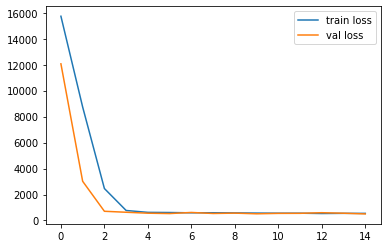

In [ ]:
##.- Accuracy
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

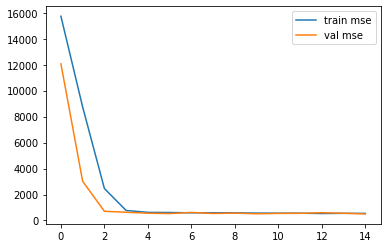

In [ ]:
##.- Loss
plt.plot(history.history['mean_squared_error'], label='train mse')
plt.plot(history.history['val_mean_squared_error'], label='val mse')
plt.legend()
plt.show()

In [ ]:
#evauate test
score= bone_age_model.evaluate(test_generator)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

42/79 [==============>...............] - ETA: 37s - loss: 0.0000e+00 - mean_squared_error: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
y_pred=bone_age_model.predict(test_generator)

In [ ]:
y_pred

array([[  350.54166 ],
       [  429.9282  ],
       [ 1982.3336  ],
       ...,
       [-1814.923   ],
       [  665.4345  ],
       [  -27.788658]], dtype=float32)

In [ ]:
test_df

,id,boneage,male
3482,5435.png,156,False
3092,5004.png,100,False
10199,12917.png,94,False
4467,6521.png,69,False
6645,8947.png,120,False
...,...,...,...
9364,11991.png,106,False
9618,12275.png,180,True
8801,11353.png,144,False
9525,12172.png,174,True


In [ ]:
y_real= test_df["boneage"]

(-500.0, 500.0)

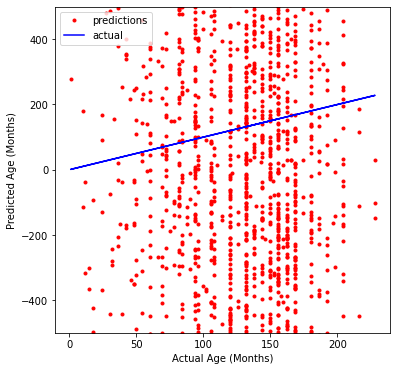

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_real, y_pred, 'r.', label = 'predictions')
ax1.plot(y_real, y_real, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')
ax1.set_ylim(-500,500)